# DDPG algorithm in flax

In [10]:
import gymnasium as gym
import numpy as np
from collections import deque
import optax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.tree_util as jtu
from jax import random
import jax.numpy as jnp
import jax

from flax.training import train_state
from flax import linen as nn  # Linen API
from tqdm import tqdm



F_CPP_MIN_LOG_LEVEL=0

## Create necessary methods to the training

In [11]:
#random process N for action exploration
def noise(noise_scale=0.1, key=random.PRNGKey(0), action_dim=2):
    return noise_scale * jax.random.normal(key, (action_dim,))

In [12]:
# Define the method to update model parameters

# update critic
@jax.jit
def update_critic(model, states, actions, y):
    def compute_critic_loss(params):
        Q = model.apply_fn(params, states, actions)
        return jnp.mean((Q - y)**2) #compute loss
    
    grad_fn = jax.grad(compute_critic_loss)
    grads = grad_fn(model.params)
    updated_model = model.apply_gradients(grads=grads)
    return updated_model

# udate actor
@jtu.Partial(jax.jit, static_argnums=(2,))
def update_actor(model, states, action_dim):
    def compute_actor_loss(params):
        actions = model.apply_fn(params, states, action_dim)
        return -jnp.mean(actions)  # Compute the actor loss
    
    grad_fn = jax.grad(compute_actor_loss)
    grads = grad_fn(model.params)
    updated_model = model.apply_gradients(grads=grads)
    return updated_model

# Define the soft update function
@jax.jit
def soft_update(target_params, source_params, tau):
    # Convert the source_params to a JAX-compatible data structure
    source_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), source_params)
    target_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), target_params)

    # Compute the updated target parameters using a soft update
    updated_params = jtu.tree_map(lambda x, y: tau * x + (1 - tau) * y, source_params_tree, target_params_tree)

    return updated_params

In [13]:
# define the replay buffer
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        indices = jax.random.choice(key, len(self.buffer), shape=(self.batch_size,), replace=True)
        batch = [self.buffer[i] for i in indices]

        return zip(*batch)

## Create actor and critic model

In [14]:
#create the actor and critic newtorks like multilayer perceptrons
class Critic(nn.Module):
    """critic model MLP"""
    
    @nn.compact
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)
    
class Actor(nn.Module):
    """actor model MLP"""
    
    @nn.compact
    def __call__(self, x, action_dim):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=action_dim)(x)
        x = nn.tanh(x)
        return x

## Algorithm

In [15]:
# define environment
env = gym.make("MountainCarContinuous-v0")
seed = 0
key = random.PRNGKey(seed)
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

In [16]:
# Randomly initialize critic network Q(s, a|θ_Q ) and actor μ(s|θ_μ ) with weights θ_Q and θ_μ .
critic_params = Critic().init(key, jnp.zeros((1, state_dim)), jnp.zeros((1, action_dim)))
actor_params = Actor().init(key, jnp.zeros((1, state_dim)), action_dim)

# define optimizers
actor_optimizer = optax.adam(learning_rate=100)
actor_opt_state = actor_optimizer.init(actor_params)

critic_optimizer = optax.adam(learning_rate=100)
critic_opt_state = critic_optimizer.init(critic_params)

# Initialize the training state for flax porpuses
critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=critic_params,
    tx=critic_optimizer
)

actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=actor_params,
    tx=actor_optimizer,
)

print(Actor().tabulate(key, (1, state_dim), action_dim))
print(Critic().tabulate(key, jnp.ones((1,action_dim)), jnp.ones((1,state_dim))))



                                Actor Summary                                
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Actor  │ - - 1        │ float32[1]   │                          │
│         │        │   - 2        │              │                          │
│         │        │ - 1          │              │                          │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ - 1          │ float32[256] │ bias: float32[256]       │
│         │        │ - 2          │              │ kernel: float32[2,256]   │
│         │        │              │              │                          │
│         │        │              │              │ 768 (3.1 KB)             │
├─────────┼────────┼──────────────┼──────────────┼─────────────

In [17]:
# Initialize target network Q_0_target and μ_0_target with weights θ_Q_target ← θ_Q , θ_μ_target ← θ_μ
target_critic_params = critic_params
target_actor_params = actor_params

# Initialize the training state for flax porpuses
target_critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=target_critic_params,
    tx=critic_optimizer
)

target_actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=target_actor_params,
    tx=actor_optimizer
)

In [18]:
# Initialize replay buffer R
buffer_size = 100000
batch_size = 10

buffer = ReplayBuffer(buffer_size, batch_size)

In [19]:
#initialize parameters
episodes = 10
gamma = 0.1
tau = 0.001
max_episode_steps = 100
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=max_episode_steps)

episodes_reward = []

#train loop
for i in tqdm(range(episodes)):
    # Initialize a random process N for action exploration
    N = noise(0.1, key, action_dim)
    # Receive initial observation state s 1
    state, info = env.reset(seed=seed)
    done = False

    while not done:
        # Select action a_t = μ(s t |θ μ ) + N t according to the current policy and exploration noise
        action = actor.apply_fn(actor.params, state, action_dim) + N

        # Execute action a t and observe reward r t and observe new state s t+1
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition (s t , a t , r t , s t+1 ) in R
        transition = (state, action, reward, observation)
        
        # buffer.append(transition)
        buffer.add(transition)

        # Sample a random minibatch of N transitions (s i , a i , r i , s i+1 ) from R
        states, actions, rewards, next_states = buffer.sample_batch()

        # Set y = r  + γQ^0 (s_{i+1} , μ^0 (s_{i+1} |θ^μ )|θ^Q ) P
        target_action = target_actor.apply_fn(target_actor_params, jnp.asarray(next_states, dtype=jnp.float16), action_dim)
        target_q = target_critic.apply_fn(target_critic_params, jnp.asarray(next_states, dtype=jnp.float16), jnp.asarray(target_action, dtype=jnp.float16))

        y = reward + gamma * (1 - terminated) * target_q

        # Update critic by minimizing the loss
        critic = update_critic(critic, jnp.asarray(states, dtype=jnp.float16), jnp.asarray(actions, dtype=jnp.float16), jnp.asarray(y, jnp.float16))

        # Update the actor policy using the sampled gradient:
        actor = update_actor(actor, jnp.asarray(states, dtype=jnp.float16), action_dim)

        # Update the target networks:
        target_actor_params = soft_update(target_actor_params, actor.params, tau)
        target_critic_params = soft_update(target_critic_params, critic.params, tau)
       
        # update if the environment is done and the current observation
        done = terminated or truncated
        # state = observation

    print(env.return_queue)
    episodes_reward.append(env.return_queue[-1])
    
    avg_reward = int(np.mean(env.return_queue))
    print("Episode:", i, "Average reward:", avg_reward)

    

env.close()

 10%|██████                                                       | 1/10 [01:25<12:53, 85.94s/it]

deque([array([-95.73358], dtype=float32)], maxlen=100)
Episode: 0 Average reward: -95


 20%|████████████▏                                                | 2/10 [02:51<11:24, 85.60s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 1 Average reward: -95


 30%|██████████████████▎                                          | 3/10 [04:17<10:01, 85.89s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 2 Average reward: -95


 40%|████████████████████████▍                                    | 4/10 [05:44<08:38, 86.38s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 3 Average reward: -95


 50%|██████████████████████████████▌                              | 5/10 [07:11<07:12, 86.42s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 4 Average reward: -95


 60%|████████████████████████████████████▌                        | 6/10 [08:38<05:46, 86.60s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 5 Average reward: -95


 70%|██████████████████████████████████████████▋                  | 7/10 [10:04<04:19, 86.38s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 6 Average reward: -95


 80%|████████████████████████████████████████████████▊            | 8/10 [11:30<02:53, 86.51s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 7 Average reward: -95


 90%|██████████████████████████████████████████████████████▉      | 9/10 [12:55<01:25, 85.80s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 8 Average reward: -95


100%|████████████████████████████████████████████████████████████| 10/10 [14:17<00:00, 85.72s/it]

deque([array([-95.73358], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32), array([-95.82894], dtype=float32)], maxlen=100)
Episode: 9 Average reward: -95


## Visualizing the training

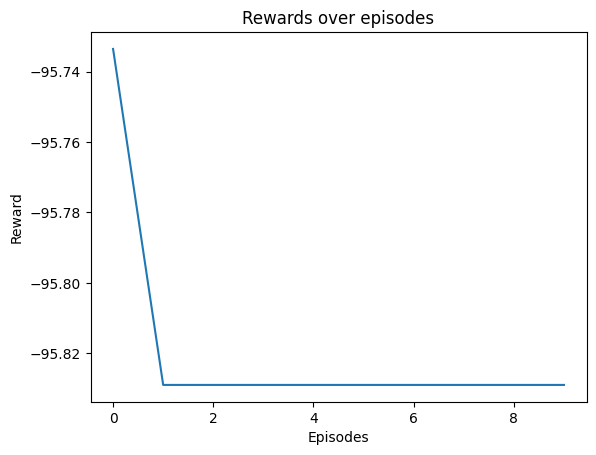

In [20]:
rewards_to_plot = [rewards for rewards in episodes_reward]

plt.plot(range(episodes), episodes_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.show()

## Stable baselines training

In [21]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

In [22]:
# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=100, log_interval=10)
model.save("ddpg_MountainCarContinuous")
vec_env = model.get_env()

del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_MountainCarContinuous")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    env.render("human")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 